# Test with pretrained models

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.nn.utils import clip_grad_norm_
import torch.nn.init as init
from sklearn.utils.class_weight import compute_class_weight
import random
import numpy as np
import pandas as pd
import os
import cpuinfo
from tqdm import tqdm
from torchinfo import summary
from PIL import Image

In [2]:
# Control randomness
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### File paths

In [3]:
train_path = "../data/Train"        # paths for your training and testing dataset
#train_path = "../data/aug_train"    
test_path = "../data/Test"          # using test dataset as validation too
input_parameter = ""                # paths for import and export custom model trainable parameters
output_parameter = "./model_parameters_efficientnetv2s_384"  # paths for import and export custom model trainable parameters

### Device of use

In [ ]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
#device = "cpu"
device_name = ""

print(f"CPU count: {os.cpu_count()}")
num_workers = min(4, os.cpu_count() // 2)  # Dynamically set num_workers
print(f"Using device: {device}")

CPU count: 16
Using device: cuda


### Pretrain Model of use from torchvision

In [5]:
from torchvision.models import efficientnet_v2_s, efficientnet_b0
model = efficientnet_b0(weights='DEFAULT')  # or efficientnet_v2_s(weights='DEFAULT')
img_size = 384 # adjust input image size for model
print(f"Using model {type(model).__name__}")

epochs = 50
batch_size = 16 # adjust to your memory

# For classifier layer if used model freezing (disable when n < 0)
n = -1
optimizer = optim.AdamW(
    [{"params": model.classifier.parameters(), "lr": 1e-2}],
    weight_decay=1e-3,
    )
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=2,
    )

# For fully unfrozen model after n epochs
optimizer2 = optim.AdamW(
    model.parameters(),
    lr=4e-4,
    weight_decay=1e-4,
    )
scheduler2 = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer2,
    mode='max',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    cooldown=0,
    threshold_mode='rel',
    threshold=0.0001,
    eps=1e-8
    )
if n < 0:
    optimizer = optimizer2
    scheduler = scheduler2

# loss_function = nn.CrossEntropyLoss() defined in Weighed Cross Entropy Loss cell
grad_clip = 5.0         # gradient clipping value

Using model EfficientNet


### Data transform/normalization and loader

In [6]:
# Calculate mean and std of dataset images
def calculate_mean_std():
    transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.CenterCrop(img_size),
        transforms.ToTensor()
    ])

    dataset = datasets.ImageFolder(root=train_path, transform=transform)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    # Initialize variables to compute mean and variance
    mean = 0.0
    var = 0.0
    total_images = 0

    for images, _ in tqdm(loader, desc="Calculating stats"):
        batch_samples = images.size(0)  # Number of images in the batch
        images = images.view(batch_samples, images.size(1), -1)  # Flatten the image pixels [B, C, H*W]
        
        # Compute batch mean and variance
        batch_mean = images.mean([0, 2])  # Mean for each channel
        batch_var = images.var([0, 2])   # Variance for each channel
        
        # Update global mean and variance
        mean += batch_mean * batch_samples
        var += batch_var * batch_samples
        total_images += batch_samples

    # Final mean and standard deviation
    mean /= total_images
    std = torch.sqrt(var / total_images)

    mean = mean.tolist()
    std = std.tolist()

    print(f"Total Images: {total_images}")
    print(f"Mean: {mean}")
    print(f"Std: {std}")

    return mean, std

In [7]:
# Precomputed mean and std
# for EfficientNetB0 and batch=16
# mean, std = calculate_mean_std()
mean = [0.7505297064781189, 0.5858979821205139, 0.5854080319404602]
std = [0.1179748997092247, 0.14000017940998077, 0.15512846410274506]

In [8]:
transform_train = transforms.Compose([
    transforms.Resize(450),
    transforms.Pad(padding=150, padding_mode='reflect'),
    transforms.RandomRotation(45, expand=False),
    transforms.CenterCrop(450),
    transforms.Resize(img_size),

    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.05),
    
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),                                       # Use the calculated mean and std
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Use the ImageNet mean and std
    transforms.RandomErasing(p=0.5, scale=(0.01, 0.05), ratio=(0.3, 10), value='random', inplace=False),
])

transform_test = transforms.Compose([   # on test dataset
    transforms.Resize(img_size),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

In [9]:
train_dataset = datasets.ImageFolder(root=train_path, transform=transform_train)
test_dataset = datasets.ImageFolder(root=test_path, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

val_data = [
    (images.to(device), labels.to(device))
    for images, labels in tqdm(test_loader, desc=f"Preloading Test Data to {device_name}", leave=False)
]

class_counts = [0] * len(train_dataset.classes)
for _, label in train_dataset.samples:
    class_counts[label] += 1

print(f"Total Classes: {len(train_dataset.classes)}")
print(f"Class counts: {class_counts}")
print(f"Classes: {train_dataset.classes}")

Total Classes: 9
Class counts: [114, 376, 95, 438, 357, 462, 77, 181, 139]
Classes: ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Weighted Cross Entropy Loss

In [10]:
class_weights = compute_class_weight(
    'balanced',
    classes=np.arange(len(train_dataset.classes)),
    y=[label for _, label in train_dataset.samples]
)

class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
loss_function = nn.CrossEntropyLoss(weight=class_weights)

print(f"Class weights: {class_weights}")

Class weights: tensor([2.1823, 0.6616, 2.6187, 0.5680, 0.6969, 0.5385, 3.2309, 1.3745, 1.7898],
       device='cuda:0')


### Model Classifier layer

In [11]:
# Edit the output layer of the model
num_classes = len(train_dataset.classes)
num_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.5),
    
    nn.Linear(num_features, 256),
    nn.BatchNorm1d(256),
    nn.LeakyReLU(),

    nn.Linear(256, num_classes),
)

# Initialize weights and biases for classifier
for m in model.classifier:
    if isinstance(m, nn.Linear):
        init.kaiming_normal_(m.weight, nonlinearity='leaky_relu')
        if m.bias is not None:
            init.constant_(m.bias, 0)

print(f"Classifier - Input features: {num_features}, Output classes: {num_classes}")

Classifier - Input features: 1280, Output classes: 9


### Configure model parameters

In [12]:
# IF NEEDED
# Load custom weight and optimizer states
# if os.path.exists(input_parameter):
#     checkpoint = torch.load("test_weights.pth", map_location=device)
#     model.load_state_dict(checkpoint['model_state_dict'])
#     optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [13]:
# Selective layer freezing
# Freeze all layers except the classifier
if n >= 0:
    for name, param in model.named_parameters():
        param.requires_grad = False
    for name, param in model.classifier.named_parameters():
        param.requires_grad = True
        print(f"Unfreezing layer: {name, param.shape}")

In [14]:
# Move model to device
model.to(device)
print(f"Model is on {next(model.parameters()).device}")

Model is on cuda:0


In [15]:
# Print model architecture
# print(summary(model, (batch_size, 3, img_size, img_size)))

In [16]:
# # DEBUG
# print(f"Model device: {next(model.parameters()).device}")
# for images, labels in train_data:
#     print(f"Input device: {images.device}")
#     break
# print(f"Device: {device}")

In [17]:
arr_train_loss = []
arr_train_acc = []
arr_test_loss = []
arr_test_acc = []

# Save model parameters
def save_model_parameters(name="", output_parameter=output_parameter):
    output_parameter = os.path.join(output_parameter, name)
    if not os.path.exists(output_parameter):
        os.makedirs(output_parameter)

    # Save model architecture
    #torch.save(model, os.path.join(output_parameter, "model_architecture.pth"))

    # Save model weights, optimizer state, and scheduler state
    torch.save({
        'model_state_dict': model.state_dict()
    }, os.path.join(output_parameter, "model_weights.pth"))
    torch.save({
        'optimizer_state_dict': optimizer.state_dict()
    }, os.path.join(output_parameter, "optimizer_weights.pth"))
    torch.save({
        'scheduler_state_dict': scheduler.state_dict()
    }, os.path.join(output_parameter, "scheduler_weights.pth"))

    # Save training logs to CSV
    data = {
        "Epoch": list(range(1, len(arr_train_loss) + 1)),
        "Train Loss": arr_train_loss,
        "Train Accuracy": arr_train_acc,
        "Test Loss": arr_test_loss,
        "Test Accuracy": arr_test_acc
    }
    df = pd.DataFrame(data)
    csv_file = os.path.join(output_parameter, "training_logs.csv")
    df.to_csv(csv_file, index=False)

## Training Epochs

In [18]:
#%%time
best_acc = 0.0

# Training loop
for epoch in range(epochs):
    # Unfreeze at epoch n and reset optimizer and scheduler
    if epoch == n:
        optimizer = optimizer2
        scheduler = scheduler2
        for name, param in model.named_parameters():
                param.requires_grad = True
        print("Unfreezing all layers")

    # Training phase
    model.train()
    current_lr = scheduler.get_last_lr()[0]
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs} [Train]", leave=False)
    for images, labels in train_bar:
        images, labels = images.to(device), labels.to(device)

        # --Non-Mixed Precision training--
        outputs = model(images)
        loss = loss_function(outputs, labels)

        optimizer.zero_grad()
        loss.backward()

        clip_grad_norm_(model.parameters(), grad_clip)  # Gradient clipping
        optimizer.step()
        # --Non-Mixed Precision training--

        # Calculate statistics
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        # Update progress bar
        train_bar.set_postfix({
            'loss': f"{running_loss / total_train:.4f}",
            'acc': f"{100. * correct_train / total_train:.2f}%"
        })

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    val_bar = tqdm(val_data, desc=f"Epoch {epoch + 1}/{epochs} [Test]", leave=False)
    with torch.no_grad():
        for images, labels in val_bar:
            outputs = model(images)
            loss = loss_function(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

            # Update progress bar
            val_bar.set_postfix({
                'loss': f"{val_loss / total_val:.4f}",
                'acc': f"{100. * correct_val / total_val:.2f}%"
            })

    # Update learning rate
    if isinstance(scheduler, torch.optim.lr_scheduler.CosineAnnealingWarmRestarts) or isinstance(scheduler, torch.optim.lr_scheduler.CosineAnnealingLR):
        scheduler.step()
    else:
        scheduler.step(torch.tensor(correct_val / total_val))

    # Print epoch summary
    print(f"Epoch {epoch + 1:>3}/{epochs} - "
          f"LR: {current_lr:.7f} | "
          f"Train Loss: {running_loss / total_train:.4f}, Train Acc: {100. * correct_train / total_train:.2f}% | "
          f"Test Loss: {val_loss / total_val:.4f}, Test Acc: {100. * correct_val / total_val:.2f}%")
    
    # Save model parameters and training logs
    arr_train_loss.append(running_loss / total_train)
    arr_train_acc.append(100. * correct_train / total_train)
    arr_test_loss.append(val_loss / total_val)
    arr_test_acc.append(100. * correct_val / total_val)

    # Save the best model
    test_acc = 100. * correct_val / total_val
    if test_acc > best_acc:
        best_acc = test_acc
        save_model_parameters(name=f"best_test_acc")

# Save model parameters at the end of training
save_model_parameters(name=f"epoch_{epoch + 1}")

Epoch   1/50 - LR: 0.0004000 | Train Loss: 1.6541, Train Acc: 37.29% | Test Loss: 1.4803, Test Acc: 50.00%


Epoch   2/50 - LR: 0.0004000 | Train Loss: 1.1404, Train Acc: 57.39% | Test Loss: 1.3500, Test Acc: 55.08%


Epoch   3/50 - LR: 0.0004000 | Train Loss: 1.0178, Train Acc: 60.74% | Test Loss: 1.2061, Test Acc: 61.86%


Epoch   4/50 - LR: 0.0004000 | Train Loss: 0.8426, Train Acc: 66.50% | Test Loss: 1.2023, Test Acc: 59.32%


Epoch   5/50 - LR: 0.0004000 | Train Loss: 0.8031, Train Acc: 68.78% | Test Loss: 1.1117, Test Acc: 59.32%


Epoch   6/50 - LR: 0.0004000 | Train Loss: 0.7671, Train Acc: 68.60% | Test Loss: 1.2280, Test Acc: 66.10%


Epoch   7/50 - LR: 0.0004000 | Train Loss: 0.6981, Train Acc: 70.57% | Test Loss: 1.0882, Test Acc: 67.80%


Epoch   8/50 - LR: 0.0004000 | Train Loss: 0.6498, Train Acc: 73.92% | Test Loss: 1.0220, Test Acc: 65.25%


Epoch   9/50 - LR: 0.0004000 | Train Loss: 0.6342, Train Acc: 74.94% | Test Loss: 1.1984, Test Acc: 64.41%


Epoch  10/50 - LR: 0.0004000 | Train Loss: 0.5935, Train Acc: 76.42% | Test Loss: 1.1201, Test Acc: 67.80%


Epoch  11/50 - LR: 0.0002000 | Train Loss: 0.4769, Train Acc: 80.17% | Test Loss: 1.0955, Test Acc: 66.95%


Epoch  12/50 - LR: 0.0002000 | Train Loss: 0.4477, Train Acc: 81.38% | Test Loss: 0.9663, Test Acc: 71.19%


Epoch  13/50 - LR: 0.0002000 | Train Loss: 0.4534, Train Acc: 81.73% | Test Loss: 1.3042, Test Acc: 65.25%


Epoch  14/50 - LR: 0.0002000 | Train Loss: 0.4044, Train Acc: 82.00% | Test Loss: 1.0666, Test Acc: 64.41%


Epoch  15/50 - LR: 0.0002000 | Train Loss: 0.3791, Train Acc: 83.30% | Test Loss: 0.9596, Test Acc: 71.19%


Epoch  16/50 - LR: 0.0001000 | Train Loss: 0.3429, Train Acc: 85.26% | Test Loss: 0.9901, Test Acc: 70.34%


Epoch  17/50 - LR: 0.0001000 | Train Loss: 0.3238, Train Acc: 85.44% | Test Loss: 0.9665, Test Acc: 68.64%


Epoch  18/50 - LR: 0.0001000 | Train Loss: 0.3143, Train Acc: 86.42% | Test Loss: 1.0194, Test Acc: 72.03%


Epoch  19/50 - LR: 0.0001000 | Train Loss: 0.3052, Train Acc: 87.05% | Test Loss: 1.0226, Test Acc: 66.95%


Epoch  20/50 - LR: 0.0001000 | Train Loss: 0.2930, Train Acc: 87.23% | Test Loss: 1.0807, Test Acc: 66.10%


Epoch  21/50 - LR: 0.0001000 | Train Loss: 0.3161, Train Acc: 86.02% | Test Loss: 1.2168, Test Acc: 65.25%


Epoch  22/50 - LR: 0.0000500 | Train Loss: 0.2730, Train Acc: 88.70% | Test Loss: 1.1962, Test Acc: 66.10%


Epoch  23/50 - LR: 0.0000500 | Train Loss: 0.2707, Train Acc: 88.30% | Test Loss: 1.2082, Test Acc: 66.95%


Epoch  24/50 - LR: 0.0000500 | Train Loss: 0.2837, Train Acc: 87.85% | Test Loss: 1.1645, Test Acc: 68.64%


Epoch  25/50 - LR: 0.0000250 | Train Loss: 0.2674, Train Acc: 88.34% | Test Loss: 1.0885, Test Acc: 66.95%


Epoch  26/50 - LR: 0.0000250 | Train Loss: 0.2517, Train Acc: 88.88% | Test Loss: 1.1949, Test Acc: 63.56%


Epoch  27/50 - LR: 0.0000250 | Train Loss: 0.2509, Train Acc: 88.97% | Test Loss: 1.1965, Test Acc: 65.25%


Epoch  28/50 - LR: 0.0000125 | Train Loss: 0.2468, Train Acc: 88.88% | Test Loss: 1.1416, Test Acc: 63.56%


Epoch  29/50 - LR: 0.0000125 | Train Loss: 0.2431, Train Acc: 89.95% | Test Loss: 1.2033, Test Acc: 66.95%


Epoch  30/50 - LR: 0.0000125 | Train Loss: 0.2377, Train Acc: 89.37% | Test Loss: 1.1555, Test Acc: 67.80%


Epoch  31/50 - LR: 0.0000063 | Train Loss: 0.2422, Train Acc: 89.82% | Test Loss: 1.1982, Test Acc: 63.56%


Epoch  32/50 - LR: 0.0000063 | Train Loss: 0.2314, Train Acc: 89.73% | Test Loss: 1.2195, Test Acc: 68.64%


Epoch  33/50 - LR: 0.0000063 | Train Loss: 0.2480, Train Acc: 88.57% | Test Loss: 1.1993, Test Acc: 65.25%


Epoch  34/50 - LR: 0.0000031 | Train Loss: 0.2519, Train Acc: 89.01% | Test Loss: 1.1890, Test Acc: 67.80%


Epoch  35/50 - LR: 0.0000031 | Train Loss: 0.2331, Train Acc: 89.73% | Test Loss: 1.2018, Test Acc: 64.41%


Epoch  36/50 - LR: 0.0000031 | Train Loss: 0.2523, Train Acc: 89.64% | Test Loss: 1.2357, Test Acc: 66.95%


Epoch  37/50 - LR: 0.0000016 | Train Loss: 0.2464, Train Acc: 89.33% | Test Loss: 1.2292, Test Acc: 66.10%


Epoch  38/50 - LR: 0.0000016 | Train Loss: 0.2379, Train Acc: 89.10% | Test Loss: 1.1874, Test Acc: 65.25%


Epoch  39/50 - LR: 0.0000016 | Train Loss: 0.2370, Train Acc: 90.08% | Test Loss: 1.2227, Test Acc: 66.95%


Epoch  40/50 - LR: 0.0000010 | Train Loss: 0.2373, Train Acc: 89.82% | Test Loss: 1.2145, Test Acc: 68.64%


Epoch  41/50 - LR: 0.0000010 | Train Loss: 0.2336, Train Acc: 90.40% | Test Loss: 1.1549, Test Acc: 66.95%


Epoch  42/50 - LR: 0.0000010 | Train Loss: 0.2480, Train Acc: 89.37% | Test Loss: 1.1913, Test Acc: 67.80%


Epoch  43/50 - LR: 0.0000010 | Train Loss: 0.2391, Train Acc: 89.77% | Test Loss: 1.1813, Test Acc: 66.10%


Epoch  44/50 - LR: 0.0000010 | Train Loss: 0.2423, Train Acc: 89.77% | Test Loss: 1.2299, Test Acc: 64.41%


Epoch  45/50 - LR: 0.0000010 | Train Loss: 0.2434, Train Acc: 89.73% | Test Loss: 1.2574, Test Acc: 65.25%


Epoch  46/50 - LR: 0.0000010 | Train Loss: 0.2208, Train Acc: 90.26% | Test Loss: 1.2120, Test Acc: 66.95%


Epoch  47/50 - LR: 0.0000010 | Train Loss: 0.2316, Train Acc: 89.91% | Test Loss: 1.1574, Test Acc: 64.41%


Epoch  48/50 - LR: 0.0000010 | Train Loss: 0.2252, Train Acc: 89.50% | Test Loss: 1.2466, Test Acc: 66.10%


Epoch  49/50 - LR: 0.0000010 | Train Loss: 0.2379, Train Acc: 89.15% | Test Loss: 1.2055, Test Acc: 63.56%


Epoch  50/50 - LR: 0.0000010 | Train Loss: 0.2351, Train Acc: 89.50% | Test Loss: 1.2713, Test Acc: 67.80%


### Training log and data export

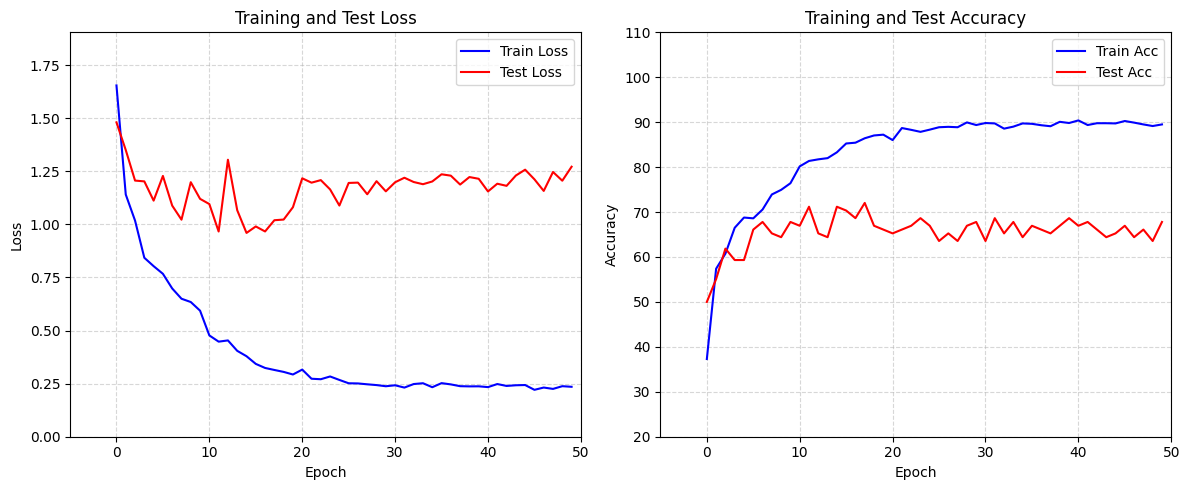

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(arr_train_loss, label='Train Loss', color='blue', linestyle='-')
plt.plot(arr_test_loss, label='Test Loss', color='red', linestyle='-')
plt.title('Training and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(np.arange(start=0, stop=len(arr_train_loss)+1, step=10))
plt.xlim(-5, len(arr_train_loss))
plt.yticks(np.arange(start=0, stop=max(arr_train_loss) + 0.25, step=0.25))
plt.ylim(0, max(arr_train_loss) + 0.25)

plt.subplot(1, 2, 2)
plt.plot(arr_train_acc, label='Train Acc', color='blue', linestyle='-')
plt.plot(arr_test_acc, label='Test Acc', color='red', linestyle='-')
plt.title('Training and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(np.arange(start=0, stop=len(arr_train_loss)+1, step=10))
plt.xlim(-5, len(arr_train_loss))
plt.yticks(np.arange(start=max(min(arr_train_acc)//10*10-10, 0), stop=max(arr_train_acc)//10*10+30, step=10))


plt.tight_layout()
# plt.savefig('loss_acc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

In [20]:
# template 2